<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Financial Time Series**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
import numpy as np
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import lag_plot
import scipy
from statsmodels.tsa.stattools import adfuller
from functools import reduce
import random
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data Preprocessing**

In [2]:
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/google.csv'
data = pd.read_csv(url)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,266.301849,266.904572,264.159851,265.514771,265.514771,4518400
1,2010-02-02,266.481171,266.481171,262.819885,264.568329,264.568329,8223000
2,2010-02-03,263.347900,270.037842,263.128723,269.400208,269.400208,6020500
3,2010-02-04,267.497345,267.995483,261.798706,262.406433,262.406433,6780600
4,2010-02-05,263.213409,265.753876,260.254517,264.653015,264.653015,6335600


In [3]:
preprocess = data[['Date', 'Close']].rename(columns={"Date": "date", "Close": "price"}).set_index('date')
preprocess.index = pd.to_datetime(preprocess.index, utc=True)
series = preprocess
series.head()

,price
date,
2010-02-01 00:00:00+00:00,265.514771
2010-02-02 00:00:00+00:00,264.568329
2010-02-03 00:00:00+00:00,269.400208
2010-02-04 00:00:00+00:00,262.406433
2010-02-05 00:00:00+00:00,264.653015


In [0]:
differenced = series
differenced = differenced.drop(columns=['price'])
differenced['price'] = ((series.price) - ((series.price).shift(1)))
differenced = differenced.dropna()
differenced.head()

,price
date,
2010-02-02 00:00:00+00:00,-0.946442
2010-02-03 00:00:00+00:00,4.831879
2010-02-04 00:00:00+00:00,-6.993775
2010-02-05 00:00:00+00:00,2.246582
2010-02-08 00:00:00+00:00,1.085938


# **LSTM**

In [0]:
print(series.head())

                                price
date                                 
2010-02-01 00:00:00+00:00  265.514771
2010-02-02 00:00:00+00:00  264.568329
2010-02-03 00:00:00+00:00  269.400208
2010-02-04 00:00:00+00:00  262.406433
2010-02-05 00:00:00+00:00  264.653015


In [0]:
# convert from float to int
#series = series.round(0).astype(int)
series.head()

,price
date,
2010-02-01 00:00:00+00:00,265.514771
2010-02-02 00:00:00+00:00,264.568329
2010-02-03 00:00:00+00:00,269.400208
2010-02-04 00:00:00+00:00,262.406433
2010-02-05 00:00:00+00:00,264.653015


In [0]:
series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-02-01 00:00:00+00:00 to 2020-01-29 00:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2516 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

## **Model Start**

In [0]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# load the dataset
dataframe = series.rename(columns={"price": "values"})
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
dataset

array([[ 265.51477],
       [ 264.56833],
       [ 269.4002 ],
       ...,
       [1433.9    ],
       [1452.56   ],
       [1458.63   ]], dtype=float32)

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [0]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1685 831


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [0]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [0]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 7.60 RMSE
Test Score: 64.87 RMSE


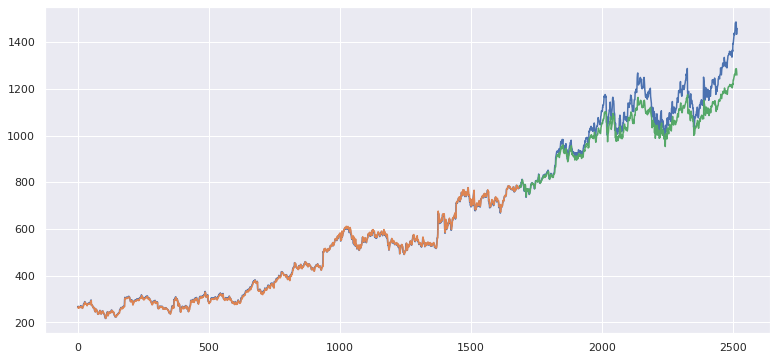

In [0]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
sns.set(rc={'figure.figsize':(13, 6)})
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# **TF - STS**

Still some signal left in the residuals of the base model. Model is not good enough yet.

This analysis is inspired by this example: 
[Atmospheric CO2 and Electricity Demand](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) - ([Github](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb))

*Pending - Work in Progress*

# **RNN**

Inspired by: https://www.tensorflow.org/guide/keras/rnn

**Import & Prepare Data**

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from tensorflow.keras import layers

print(tf.__version__)

2.2.0-rc4


In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4423680/4422102 [==============================] - 0s 0us/step


**Define Hyperparameter**

In [0]:
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy'
dropout = 0.2
epochs = 5

**Create Model**

In [0]:
model = tf.keras.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout))
model.add(layers.Dense(10, activation='softmax'))

**Display Model Topology**

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


**Compile Model**

In [0]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

**Prepare TensorBoard**

In [0]:
# Load Library
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

**Train Model**

In [0]:
model.fit(x=x_train, y=y_train, epochs=epochs, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4977 - accuracy: 0.8212 - val_loss: 0.4237 - val_accuracy: 0.8482
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3818 - accuracy: 0.8600 - val_loss: 0.3874 - val_accuracy: 0.8635
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3513 - accuracy: 0.8710 - val_loss: 0.3684 - val_accuracy: 0.8685
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3297 - accuracy: 0.8791 - val_loss: 0.3627 - val_accuracy: 0.8713
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3148 - accuracy: 0.8837 - val_loss: 0.3431 - val_accuracy: 0.8769


**Results in TensorBoard**

In [0]:
%tensorboard --logdir logs/

**Compressed version**

In [0]:
# Create Model

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])


# Train Model

def train_model():
  
  model = create_model()
  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  model.fit(x=x_train, 
            y=y_train, 
            epochs=5, 
            validation_data=(x_test, y_test))

train_model()